In [12]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [13]:
file = uproot.open("/Users/jczettle/geant4/PHONON_Bkgnds/shielded_10kneutrons.root")

# Inspect the file to find available trees
print(file.keys())

# Access a specific TTree (replace with actual tree name, e.g., "Events")
tree = file["Hits"]
tree2 = file["Primary"]

# List available branches
print(tree.keys())

# Convert to a pandas DataFrame
# You can select specific branches or load all of them
df = tree.arrays(library="pd")

df2 = tree2.arrays(library="pd") # primary particle information

# Display the DataFrame
print(df2.head())
print(df.head())

#convert the particle name to a string type instead of some "awkward" bytes type
df['ParticleName'] = df['ParticleName'].astype(str)
df['ParticleDefinition'] = df['ParticleDefinition'].astype(str)

print(df.dtypes)
df.info()

#access the file with no shielding in place

file2 = uproot.open("/Users/jczettle/geant4/PHONON_Bkgnds/no_shield_10kneutrons.root")

# Access the TTree
tree_no_shield = file2["Hits"]
tree2_no_shield = file2["Primary"]
# Convert to a pandas DataFrame
df_no_shield = tree_no_shield.arrays(library="pd")
df2_no_shield = tree2_no_shield.arrays(library="pd") # primary particle information

#convert the particle name to a string type instead of some "awkward" bytes type
df_no_shield['ParticleName'] = df_no_shield['ParticleName'].astype(str)
df_no_shield['ParticleDefinition'] = df_no_shield['ParticleDefinition'].astype(str)
print(df_no_shield.dtypes)
print(df_no_shield.info())


['Primary;1', 'Hits;1']
['EventID', 'TrackID', 'PDGCode', 'ParticleName', 'ParticleDefinition', 'Edep', 'PositionX', 'PositionY', 'PositionZ', 'HitTime']
   EventID  TrackID  PDGCode  PrimaryEnergy  PrimaryPosX  PrimaryPosY  \
0      0.0      1.0   2112.0      39.147117          NaN          NaN   
1      1.0      1.0   2112.0      73.455338          NaN          NaN   
2      2.0      1.0   2112.0     293.862864          NaN          NaN   
3      3.0      1.0   2112.0     287.525587          NaN          NaN   
4      4.0      1.0   2112.0     161.897628          NaN          NaN   

   PrimaryPosZ  PrimaryMomentumX  PrimaryMomentumY  PrimaryMomentumZ  
0          NaN               1.0               0.0               0.0  
1          NaN               1.0               0.0               0.0  
2          NaN               1.0               0.0               0.0  
3          NaN               1.0               0.0               0.0  
4          NaN               1.0               0.0  

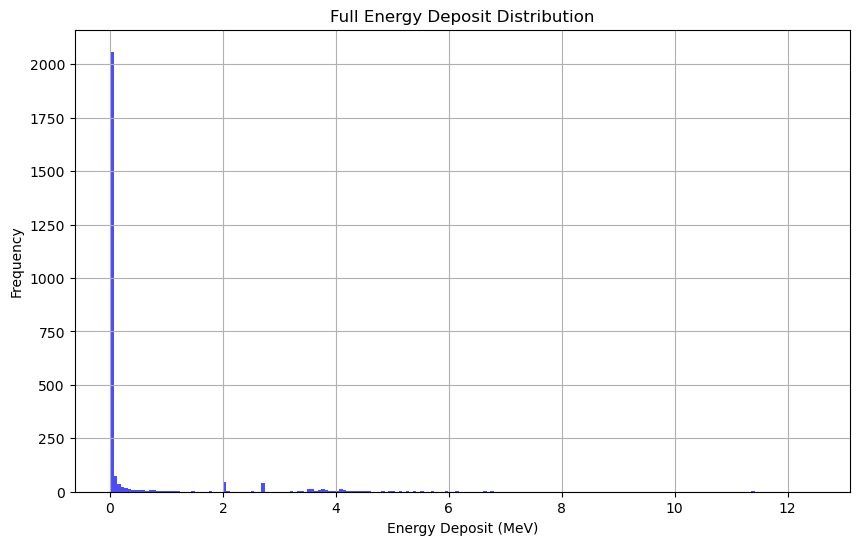

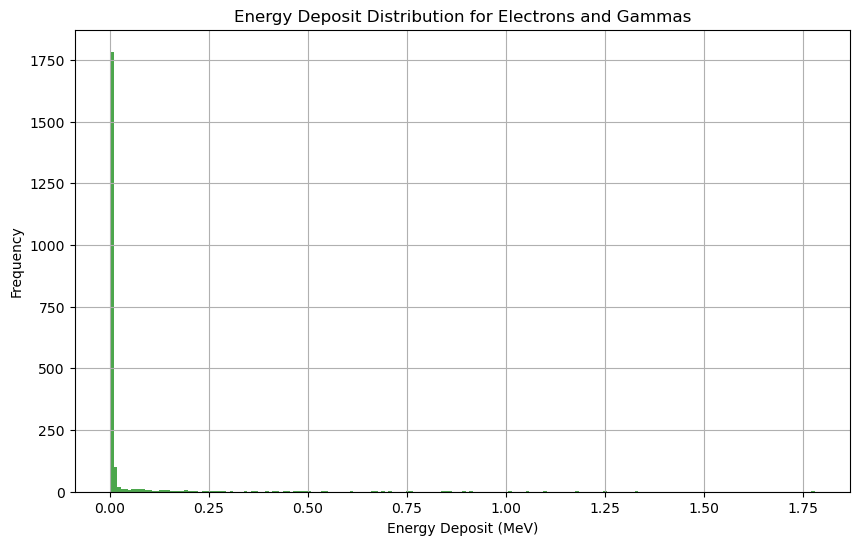

<Figure size 1000x600 with 0 Axes>

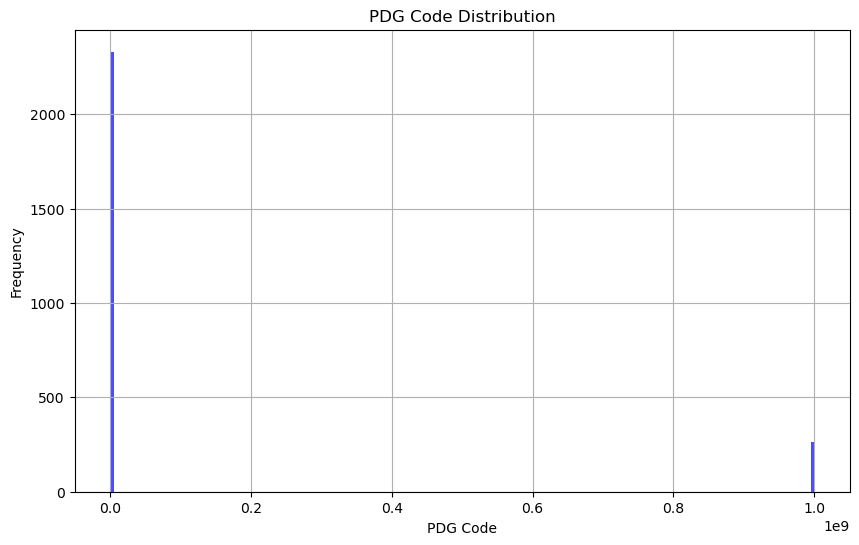

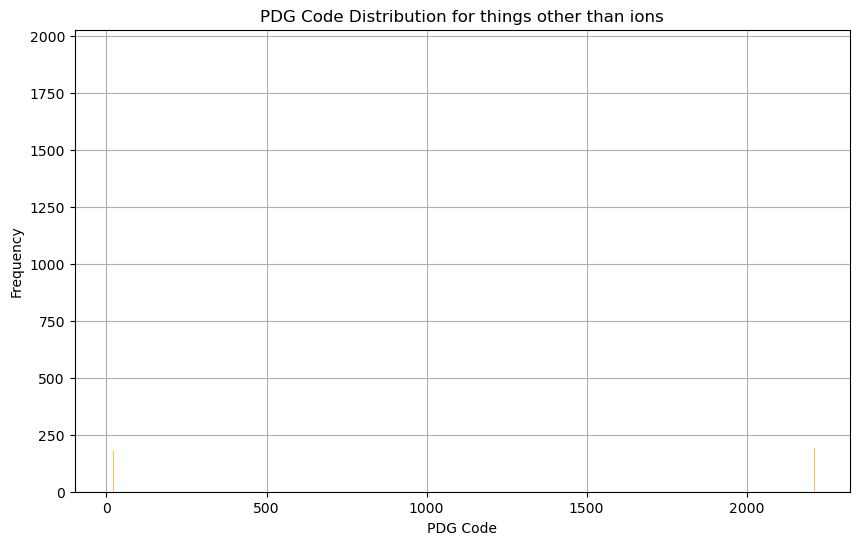

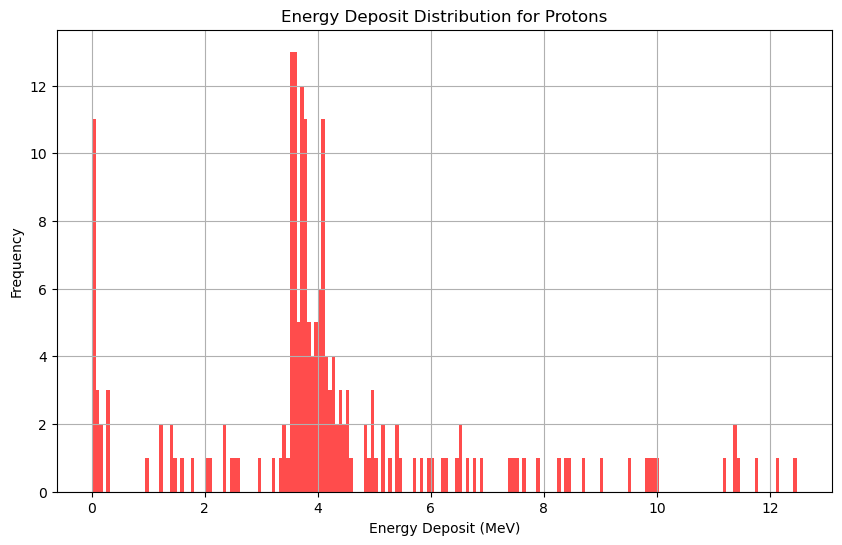

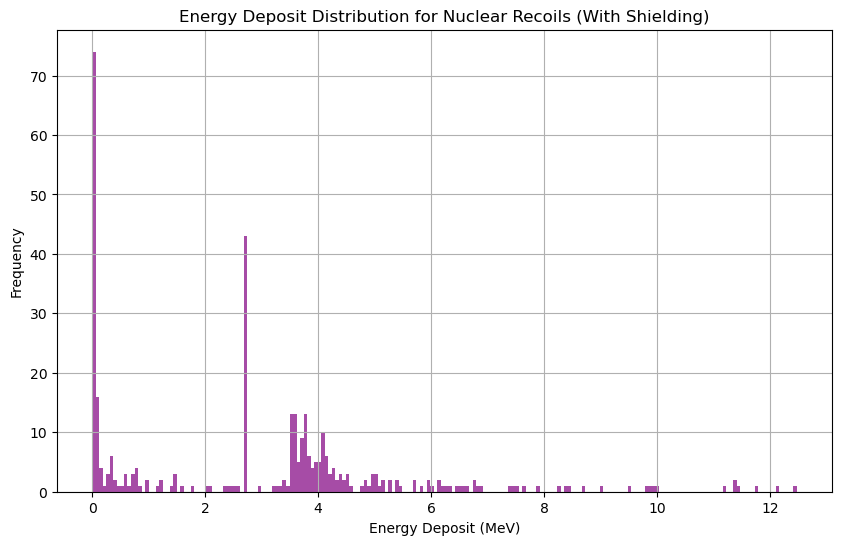

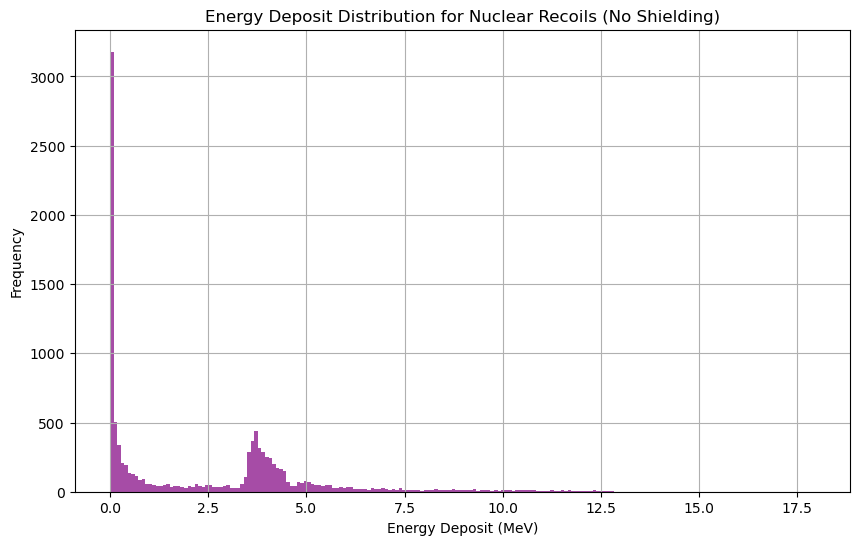

In [19]:
df.describe()  # Get a summary of the data
mask = df['Edep'] > 0  # Filter for positive energy deposits
mask2 = df['PDGCode'] == 11 # Filter for gamma or electrons
mask3 = df['PDGCode'] == 22 # Filter for gamma particles
mask4 = df['PDGCode'] == 2212 # Filter for protons
mask_nr = df['ParticleName'].str.contains('Nb', case=False, na=False) | df['ParticleName'].str.contains('Li', case=False, na=False)  | df['ParticleName'].str.contains('O', case=False, na=False)  # Filter for Li, Nb, or O nuclear recoils
el_gamma_df = df[mask2 | mask3]
proton_df = df[mask4]
no_ions_df = df[mask2 | mask3 | mask4]
nr_df = df[mask_nr]

# Plotting the energy deposit distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Edep'], bins=200, color='blue', alpha=0.7)
plt.title('Full Energy Deposit Distribution')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plotting the energy deposit distribution for electrons and gammas
plt.figure(figsize=(10, 6))
plt.hist(el_gamma_df['Edep'], bins=200, color='green', alpha=0.7)
plt.title('Energy Deposit Distribution for Electrons and Gammas')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

#plot the pdg code
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.hist(df['PDGCode'], bins=200, color='blue', alpha=0.7)
plt.title('PDG Code Distribution')
plt.xlabel('PDG Code')
plt.ylabel('Frequency')
plt.grid()
plt.show()

#plot the pdg code for no ions
plt.figure(figsize=(10, 6))
plt.hist(no_ions_df['PDGCode'], bins=2500, color='orange', alpha=0.7)
plt.title('PDG Code Distribution for things other than ions')
plt.xlabel('PDG Code')
plt.ylabel('Frequency')
plt.grid()
plt.show()  

# Plotting the energy deposit distribution for protons
plt.figure(figsize=(10, 6))
plt.hist(proton_df['Edep'], bins=200, color='red', alpha=0.7)
plt.title('Energy Deposit Distribution for Protons')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plotting the energy deposit distribution for nuclear recoils
plt.figure(figsize=(10, 6))
plt.hist(nr_df['Edep'], bins=200, color='purple', alpha=0.7)
plt.title('Energy Deposit Distribution for Nuclear Recoils (With Shielding)')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig("10kneutronShielded_LiNbO3block_NRDistro.pdf")
plt.show()

mask_nr_ns = df_no_shield['ParticleName'].str.contains('Nb', case=False, na=False) | df_no_shield['ParticleName'].str.contains('Li', case=False, na=False)  | df_no_shield['ParticleName'].str.contains('O', case=False, na=False)  # Filter for Li, Nb, or O nuclear recoils
nr_ns_df = df_no_shield[mask_nr_ns]
# Plotting the energy deposit distribution for nuclear recoils in no shielding
plt.figure(figsize=(10, 6))
plt.hist(nr_ns_df['Edep'], bins=200, color='purple', alpha=0.7)
plt.title('Energy Deposit Distribution for Nuclear Recoils (No Shielding)')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig("10kneutron_LiNbO3blockOnly_NRDistro.pdf")
plt.show()




   EventID  TrackID  PDGCode      Edep   PositionX   PositionY   PositionZ  \
0      0.0     13.0     22.0  0.000018   47.838864  -82.592360  106.208062   
1      0.0     49.0     11.0  0.030757   47.834800  -82.582697  106.213273   
2      0.0     48.0     11.0  0.003863   73.100979 -106.250163   50.309725   
3      0.0     47.0     11.0  0.000354   81.081152  -66.414734   90.533775   
4      0.0     46.0     11.0  0.005151  106.395708  -58.614425  110.646090   

            r^2  
0   9110.054834  
1   9108.069983  
2  16632.850262  
3  10985.070147  
4  14755.697594  
    EventID  TrackID  PDGCode      Edep  PositionX   PositionY   PositionZ  \
46      0.0    737.0   2212.0  5.927697 -41.630480 -183.204787 -139.686665   
47      0.0    737.0   2212.0  4.817258 -43.340732 -186.497101 -140.557846   
48      0.0    737.0   2212.0  4.465380 -44.705139 -189.188469 -141.194311   
49      0.0    737.0   2212.0  4.148785 -45.773249 -191.368521 -141.672486   
50      0.0    737.0   2212.0  3.

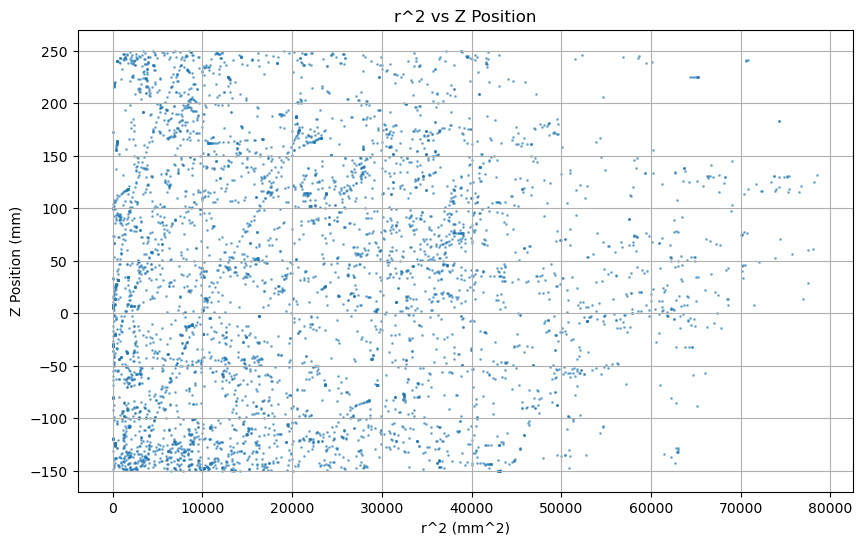

In [22]:

df["r^2"] = df["PositionX"]**2 + df["PositionY"]**2
print(df.head())
masked_df = df[mask4]
print(masked_df.head())
#plot the r^2 vs z distribution
plt.figure(figsize=(10, 6))
plt.scatter(df["r^2"], df["PositionZ"], alpha=0.5, s=1)
plt.title('r^2 vs Z Position')
plt.xlabel('r^2 (mm^2)')
plt.ylabel('Z Position (mm)')
plt.grid()
plt.show()


Fit parameters: a=-1.6066616208380666e-05, b=3.0260414218602387e-06, c=1.0000160665963203


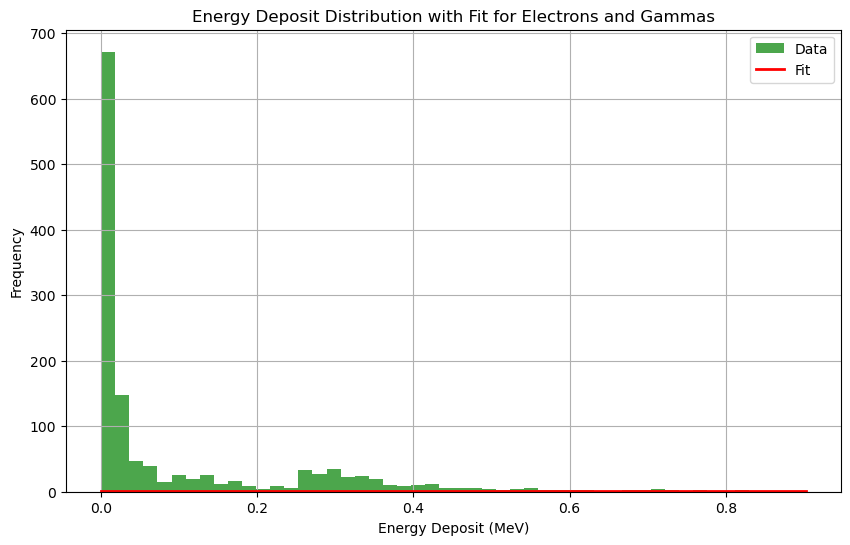

In [28]:
#define a fit function for the energy deposit distribution
def fit_function(x, a, b, c):
    return a * np.exp(-b * x) + c
# Fit the energy deposit distribution for electrons and gammas
from scipy.optimize import curve_fit
params, covariance = curve_fit(fit_function, df['Edep'], np.ones_like(df['Edep']), p0=[300, 1e-3, 0.1])
a, b, c = params    
print(f"Fit parameters: a={a}, b={b}, c={c}")
# Plot the fit
x_fit = np.linspace(0, el_gamma_df['Edep'].max(), 100)
y_fit = fit_function(x_fit, a, b, c)
plt.figure(figsize=(10, 6))
plt.hist(el_gamma_df['Edep'], bins=50, color='green', alpha=0.7, label='Data')
plt.plot(x_fit, y_fit, color='red', label='Fit', linewidth=2)
plt.title('Energy Deposit Distribution with Fit for Electrons and Gammas')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
            

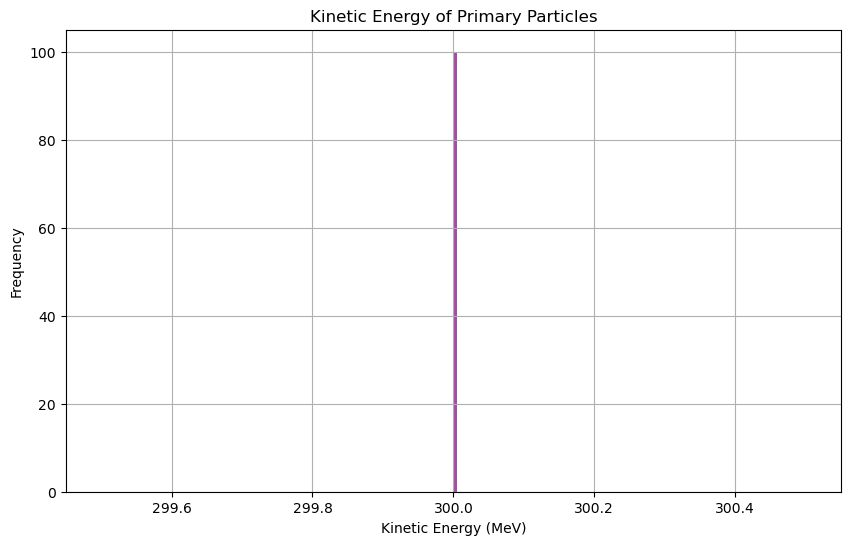

In [41]:
#plot the energy from the primary particles
plt.figure(figsize=(10, 6))
plt.hist(df2['PrimaryEnergy'], bins=200, color='purple', alpha=0.7)
plt.title('Kinetic Energy of Primary Particles')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Frequency')             
plt.grid()
plt.show()